# Feature selection
#### importing libraries and reading in data

In [32]:
import csv
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.model_selection import train_test_split
from graphviz import Source # for drawing decision tree
from IPython.display import SVG # for drawing decision tree
import numpy as np

motifNames = []
classes = []
rawData = []
with open('data/raw.csv') as csvfile: 
    readCSV = csv.reader(csvfile, delimiter=',')
    motifNames = next(readCSV)[1:-1] #remove left most column and 'class'
    for row in readCSV:
        rawData.append(row[1:-1])
        classes.append(row[-1])
print ("number of motif names:", len(motifNames)) 
print ("number of recorded classes:", len(classes))  
print ("Data Dimentions:", len(rawData),"rows,", len(rawData[0]), "cols")


number of motif names: 3519
number of recorded classes: 145
Data Dimentions: 145 rows, 3519 cols


#### Transpose data and convert to true / false for simpler code

In [33]:
# convert data to T/F
for row in range(len(rawData)):
        for cell in range(len(rawData[row])):
            if(rawData[row][cell] == '0.0'):
                rawData[row][cell] = False
            elif(rawData[row][cell] == '1.0'):
                rawData[row][cell] = True
                
# convert data to T/F
for cell in range(len(classes)):
    if(classes[cell] == '0.0'):
        classes[cell] = False
    elif(classes[cell] == '1.0'):
        classes[cell] = True

    
# transpose data
tData = [list(i) for i in zip(*rawData)]
print ("Transposed Dimentions:", len(tData),"rows,", len(tData[0]), "cols")  

Transposed Dimentions: 3519 rows, 145 cols


#### Count how many times each motif occurs in the positive and negative classes

In [34]:
posCounts = []
negCounts = []

for row in range(len(tData)):
    posCount = 0
    negCount = 0
    for col in range(len(tData[row])):
        if(tData[row][col] == True):
            if(classes[col] == True):
                posCount += 1 
            elif(classes[col] == False):
                negCount += 1
    posCounts.append(posCount)
    negCounts.append(negCount)
    
print("first:", posCounts[0], "pos,", negCounts[0], "neg")
print("last:", posCounts[-1], "pos,", negCounts[-1], "neg")
print("max pos: ", max(posCounts))
print("max neg: ", max(negCounts))

first: 5 pos, 2 neg
last: 2 pos, 3 neg
max pos:  13
max neg:  106


#### create plots based on counts

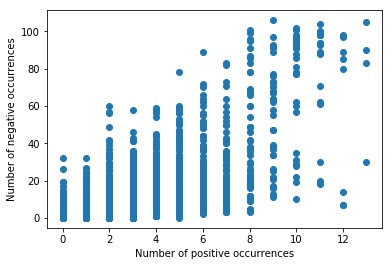

In [35]:
plt.scatter(posCounts, negCounts)
plt.xlabel("Number of positive occurrences")
plt.ylabel("Number of negative occurrences")
plt.show()


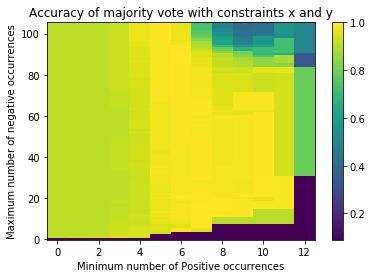

In [82]:
heatData = []
for maxNeg in range(max(negCounts)):
    heatDataRow = []
    for minPos in range(max(posCounts)):
        predictions = [0] * len(classes)
        
        for motif in range(len(posCounts)):
            if(posCounts[motif] > minPos and negCounts[motif] < maxNeg):
                for seq in range(len(classes)):
                    if(tData[motif][seq]):
                        predictions[seq] += 1.0
                    else:
                        predictions[seq] -= 1.0
        tp = 0
        fp = 0
        tn = 0
        fn = 0
        for i in range(len(classes)):
            if(predictions[i] >= 0):
                if(classes[i]):
                    tp += 1.0
                else:
                    fp += 1.0
            else:
                if(classes[i]):
                    fn += 1.0
                else:
                    tn += 1.0
        heatDataRow.append((tp+tn)/(tp+tn+fp+fn))
    heatData.append(heatDataRow)
        
        
    
#         print("Sensitivity:",tp/(tp+fn))
#         print("Specificity:",tn/(tn+fp))
#         print("Accuracy:",(tp+tn)/(tp+tn+fp+fn))

# import matplotlib as mpl
# import numpy as np

img = plt.imshow(np.array(heatData),interpolation='nearest')

plt.colorbar() # make a color bar
plt.axis('auto')
plt.gca().invert_yaxis()
plt.title("Accuracy of majority vote with constraints x and y")
plt.xlabel("Minimum number of Positive occurrences")
plt.ylabel("Maximum number of negative occurrences")
plt.show()

#### create lasso scores

In [6]:
from sklearn import linear_model
clf = linear_model.Lasso(alpha=.001)
clf.fit(rawData, classes)
lassoScores = clf.coef_
print(len(lassoScores))

3519


#### split data by if it has a positive and if it has a negative occurance

In [7]:
never = []
neverMotifNames = []
mixed = []
mixedMotifNames = []
right = []
rightMotifNames = []
bottom = []
bottomMotifNames = []
ratio = []
ratioMotifNames = []
lasso = []
lassoMotifNames = []
for row in range(len(posCounts)):
    if negCounts[row] == 0 and posCounts[row] == 0:
        never.append(tData[row])
        neverMotifNames.append(motifNames[row])
    else:
        if posCounts[row] >= max(posCounts) - 1:
            right.append(tData[row])
            rightMotifNames.append(motifNames[row])
        if negCounts[row] < 3:
            bottom.append(tData[row])
            bottomMotifNames.append(motifNames[row])
        if posCounts[row] > 0 and negCounts[row] > 0:
            mixed.append(tData[row])
            mixedMotifNames.append(motifNames[row])
        if (posCounts[row] / max(posCounts)) / (1+negCounts[row]/max(negCounts)) > .5:
            ratio.append(tData[row])
            ratioMotifNames.append(motifNames[row])
        if lassoScores[row] > 0:
            lasso.append(tData[row])
            lassoMotifNames.append(motifNames[row])            
            
print(len(lasso))

108


#### create a decision tree and train it on mixedData

In [8]:
selected = lasso
selectedNames = lassoMotifNames

selectedTree = tree.DecisionTreeClassifier()
selectedData = [list(i) for i in zip(*selected)]
x_train, x_test, y_train, y_test = train_test_split(selectedData, classes, test_size=0.33)
selectedTree = selectedTree.fit(x_train, y_train)

#### display the tree we've genorated

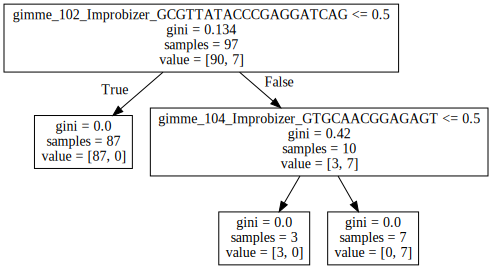

In [9]:
selectedPredictions = selectedTree.predict(x_test)
graph = Source( tree.export_graphviz(selectedTree, out_file=None, feature_names=selectedNames))
SVG(graph.pipe(format='svg'))

#### count true positves, flase negatives etc. and calculate metrics

In [10]:
tp = 0
fp = 0
tn = 0
fn = 0
for i in range(len(selectedPredictions)):
    if(selectedPredictions[i]):
        if(y_test[i]):
            tp += 1
        else:
            fp += 1
    else:
        if(y_test[i]):
            fn += 1
        else:
            tn += 1
print("true positives:", tp)
print("false positives:", fp)
print("true negatives:", tn)
print("false negatives:", fn)
if fp > 0:
    print("true positive to false positive ratio:",tp/fp)
if fn > 0:
    print("true negative to false negative ratio:",tn/fn)
print("Sensitivity:",tp/(tp+fn))
print("Specificity:",tn/(tn+fp))
print("Accuracy:",(tp+tn)/(tp+tn+fp+fn))

true positives: 4
false positives: 0
true negatives: 42
false negatives: 2
true negative to false negative ratio: 21.0
Sensitivity: 0.6666666666666666
Specificity: 1.0
Accuracy: 0.9583333333333334


In [11]:
from sklearn import linear_model
clf = linear_model.Lasso(alpha=.001)
clf.fit(rawData, classes)
print(clf.coef_)

[ 0.          0.01633253  0.06283913 ...,  0.          0.          0.        ]
